In [1]:
import os
from dotenv import find_dotenv, load_dotenv
import base64
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

_ = load_dotenv(find_dotenv())

os.chdir('/home/gpievanitrapletti/genai/multimodality/clip-classifier')

In [22]:
# DATA_PATH = 'data/caltech256_subset/caltech256_subset'

DATA_PATH = 'data/stairs_dataset_20231219/stairs_dataset'
GT_PATH = 'data/stairs_dataset_20231219/stairs_dataset_annotation.csv'

# <ins> IMAGE CAPTIONING

In [3]:
def caption_image(filepath, prompt, max_output_tokens=300, openai_key=os.environ['OPENAI_API_KEY']):

    with open(filepath, "rb") as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai_key}"
    }

    payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": prompt
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded_image}",
                "detail": "low"
            }
            }
        ]
        }
    ],
    "max_tokens": max_output_tokens
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    if 'error' in response.json().keys():
        print(response.json()['error']['message'])
    else:
        return response.json()['choices'][0]['message']['content']

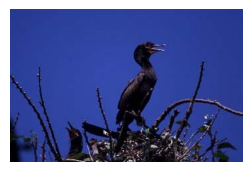

In [79]:
image_path = 'data/caltech256_subset/caltech256_subset/caltech_008.jpg'
image = Image.open(image_path)

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')
plt.show()

In [82]:
prompt = 'Caption the image.'

caption_image(filepath=image_path, prompt=prompt, max_output_tokens=70)

You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.


# <ins> STAIRS CLASSIFICATION BY JUST GPT-4V

In [23]:
filepaths = sorted([os.path.join(DATA_PATH, fp) for fp in os.listdir(DATA_PATH)])
print(len(filepaths))
print(filepaths[:3])

197
['data/stairs_dataset_20231219/stairs_dataset/stairs_001.jpg', 'data/stairs_dataset_20231219/stairs_dataset/stairs_002.jpg', 'data/stairs_dataset_20231219/stairs_dataset/stairs_003.jpg']


In [19]:
prompt = '''Identify the type of staircase in the provided picture. The type is one of the following:
- straight: a straight staircase, that is, without any turns.
- angular: a staircase that is either a L-shaped or a U-shaped staircase, that it staircases that one or more 90-degree or 180 degree turn.
- bent:  a staircase that is either a curved or a spiral staircase.

You must return just the type. In other words, you must return just straight, angular, or bent.
'''

In [64]:
answers = []
for filepath in tqdm(filepaths):
    answer = caption_image(filepath=filepath, prompt=prompt)
    answers.append(answer.lower())

100%|██████████| 197/197 [14:41<00:00,  4.47s/it]


In [6]:
# with open('output/gpt4v_stairs_predictions.json', 'w') as f:
#     json.dump(answers, f)

# Load
with open('output/gpt4v_stairs_predictions.json', 'r') as f:
    answers = json.load(f)

len(answers)

197

## EVALUATION

In [7]:
df = pd.read_csv(GT_PATH)
df.head(3)

,filename,GT
0,stairs_001,bent
1,stairs_002,straight
2,stairs_003,bent


In [ ]:
# Variation between two runs on the first 10 images
# 1 prediction changed
# format = (gt, pred)

# ('bent', 'bent')
# ('straight', 'bent')
# ('bent', 'bent')
# ('angular', 'angular')
# ('straight', 'straight')
# ('straight', 'straight')
# ('bent', 'bent')
# ('bent', 'bent')
# ('angular', 'bent')
# ('bent', 'bent')

# ('bent', 'bent')
# ('straight', 'bent')
# ('bent', 'bent')
# ('angular', 'straight')
# ('straight', 'straight')
# ('straight', 'straight')
# ('bent', 'bent')
# ('bent', 'bent')
# ('angular', 'bent')
# ('bent', 'bent')

In [8]:
gts = df.GT.to_list()
preds = answers

In [9]:
def compute_accuracy(gts, preds, category=None):
    gts = np.array(gts)
    preds = np.array(preds)
    if category: # compute accuracy of a single class
        binary_gts = gts == category
        binary_preds = preds == category
        v = np.array(binary_gts) == np.array(binary_preds)
        accuracy = round(v.sum() / v.shape[0], 2)
        return accuracy
    else: # compute overall accuracy
        v = np.array(gts) == np.array(preds)
        accuracy = round(v.sum() / v.shape[0], 2)
        return accuracy
    
# In the approach by category, if a item doesn't belong to 'category', its GT becomes 0.
# if neither the prediction belongs to 'category', its PRED becomes 0.
# This case would be considered as a TP, even if the model made an incorrect
# prediction with respect to the other class.
# Example: GT is B and the model predicted A. But we are considering category C,
# so both GT and PRED become 0, thus a TN --> this raises the accuracy score even
# if the model made a mistake. This means that computing accuracy per class yields
# higher accuracies.

In [10]:
compute_accuracy(gts, preds)

0.74

In [11]:
compute_accuracy(gts, preds, 'angular'), compute_accuracy(gts, preds, 'bent'), compute_accuracy(gts, preds, 'straight')

(0.78, 0.9, 0.8)

In [12]:
# Percentage of correct identifications over the entire category (TPR)
def compute_tpr(gts, preds, category):
    gts = np.array(gts) == category
    preds = np.array(preds) == category

    mask = gts == 1
    category_gts = gts[mask]
    category_preds = preds[mask]

    v = category_gts == category_preds
    perc = round(v.sum() / v.shape[0], 2)

    return perc

In [13]:
compute_tpr(gts, preds, 'angular'), compute_tpr(gts, preds, 'bent'), compute_tpr(gts, preds, 'straight')

# Interpretation: on 100 'angular' stairs, 41 were correctly identified as 'angular'.

(0.41, 0.97, 0.78)

In [160]:
# metric for 'angular' may have dropped with respect to accuracy because it is the class with less examples, therefore the number of TN in the
# computation of accuracy is higher (as said above), thus yielding higher accuracy.

In [14]:
# This shows that GPT-4V struggled in recognizing 'angular' strairs and labelled them instead as either 'bent' or 'straight'.
print('angular: ', round((np.array(preds) == 'angular').sum() / (np.array(gts) == 'angular').sum(), 2))
print('bent: ', round((np.array(preds) == 'bent').sum() / (np.array(gts) == 'bent').sum(), 2))
print('straight: ', round((np.array(preds) == 'straight').sum() / (np.array(gts) == 'straight').sum(), 2))

angular:  0.56
bent:  1.2
straight:  1.17


## EVALUATION ON VALIDATION SUBSET

In [48]:
import yaml
from box import Box
from src.datamodule import CCDataModule

with open('config.yaml', 'r') as f:
    cfg = Box(yaml.safe_load(f))

datamodule = CCDataModule(
    encoder_name=cfg.encoder_name,
    image_path=cfg.image_path,
    gt_path=cfg.gt_path,
    val_size=cfg.val_size,
    test_size=cfg.test_size,
    batch_size=cfg.batch_size,
    seed=cfg.seed,
)

datamodule.prepare_data()
val_filepaths = datamodule.val_filepaths
len(val_filepaths)

30

In [33]:
val_gts, val_preds = [], []
for filepath, gt, pred in zip(filepaths, gts, preds):
    if filepath in val_filepaths:
        val_gts.append(gt)
        val_preds.append(pred)

len(val_gts), len(val_preds)

(30, 30)

In [35]:
print(compute_accuracy(val_gts, val_preds))
print(compute_accuracy(val_gts, val_preds, 'angular'), compute_accuracy(val_gts, val_preds, 'bent'), compute_accuracy(val_gts, val_preds, 'straight'))

0.67
0.7 0.9 0.73


In [36]:
print(compute_tpr(val_gts, val_preds, 'angular'), compute_tpr(val_gts, val_preds, 'bent'), compute_tpr(val_gts, val_preds, 'straight'))

0.22 1.0 0.7


# <ins> STAIRS CAPTIONING

In [73]:
# Create dummy captioning for tests (basically it's the GT) 
map = {
    'angular': 'A L-shaped or U-shaped staircase',
    'bent': 'A curved or spiral staircase',
    'straight': 'A straight staircase'
}

# with open(fp, 'w') as f:
#     for gt in gts:
#         f.write(f'{map[gt]}\n')

captions = [map[gt] for gt in gts]
df1 = pd.DataFrame({'filename': [os.path.splitext(os.path.basename(fp))[0] for fp in filepaths],
                    'caption': captions,
})

df1.head(3)

df1.to_csv('data/stairs_dataset_20231219/stairs_dataset_captions_dummy.csv', index=False)

In [37]:
prompt = '''You will be provided with the picture of a staircase. 
Please caption the structure of the staircase.
You must use no more than 70 words.
'''

In [ ]:
answers = []
for filepath in tqdm(filepaths[:10]):
    answer = caption_image(filepath=filepath, prompt=prompt, max_output_tokens=70)
    answers.append(answer.lower())

In [ ]:
# QUOTA EXCEEDED!
# Retry again